<a href="https://colab.research.google.com/github/Thamindu17/BTC/blob/main/btc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance xgboost scikit-learn matplotlib ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c8b2551e8c0910d06be7f61895c9be2f04ca6483f9263381c2f6122cd0d32c90
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import ta


In [3]:
# Load 1 year of hourly BTC data
btc = yf.download("BTC-USD", period="365d", interval="1h")
btc['Close'] = btc['Close'].squeeze()
btc.dropna(inplace=True)
btc.head()


/tmp/ipython-input-3-1389296088.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", period="365d", interval="1h")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2024-07-30 00:00:00+00:00,66543.687500,66830.750000,65931.367188,66786.765625,0
2024-07-30 01:00:00+00:00,66187.335938,66833.828125,66088.648438,66574.304688,374165504
2024-07-30 02:00:00+00:00,66392.710938,66440.796875,65997.156250,66199.609375,0
2024-07-30 03:00:00+00:00,66593.695312,66628.000000,66384.859375,66407.070312,0
2024-07-30 04:00:00+00:00,66683.882812,66742.515625,66523.992188,66600.960938,0


In [8]:
import yfinance as yf
import pandas as pd
import ta

# Step 1: Download BTC data
btc_df = yf.download("BTC-USD", period="365d", interval="1h")
close = btc_df['Close']

# Step 2: Fix Close to be a true Series (avoid 2D)
close = pd.Series(close.to_numpy().flatten(), index=btc_df.index)

# Step 3: Create your feature DataFrame
btc = pd.DataFrame(index=btc_df.index)
btc['Close'] = close
btc['MA5'] = close.rolling(window=5).mean()
btc['MA10'] = close.rolling(window=10).mean()
btc['MA20'] = close.rolling(window=20).mean()

# ✅ RSI works now
rsi = ta.momentum.RSIIndicator(close=close, window=14)
btc['RSI'] = rsi.rsi()

btc['Volatility'] = close.pct_change().rolling(window=24).std()
btc['Prev_Close'] = close.shift(1)

# Clean
btc.dropna(inplace=True)
btc.head()


/tmp/ipython-input-8-2659486112.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_df = yf.download("BTC-USD", period="365d", interval="1h")
[*********************100%***********************]  1 of 1 completed


,Close,MA5,MA10,MA20,RSI,Volatility,Prev_Close
Datetime,,,,,,,
2024-07-31 00:00:00+00:00,66342.890625,66233.810938,66114.375781,66331.541406,50.721518,0.003389,66215.203125
2024-07-31 01:00:00+00:00,66267.023438,66257.943750,66116.616406,66320.259766,48.746449,0.003210,66342.890625
2024-07-31 02:00:00+00:00,66109.312500,66221.178125,66108.810156,66288.458594,44.837799,0.003179,66267.023438
2024-07-31 03:00:00+00:00,66066.515625,66200.189062,66132.024219,66246.060547,43.811194,0.003106,66109.312500
2024-07-31 04:00:00+00:00,65687.242188,66094.596875,66125.445312,66193.391797,35.954530,0.003272,66066.515625


In [9]:
btc['Target'] = btc['Close'].shift(-1)  # next-hour price
btc.dropna(inplace=True)


In [10]:
from sklearn.model_selection import train_test_split

X = btc.drop(['Target'], axis=1)
y = btc['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ⚠️ No shuffle for time series
)


In [11]:
!pip install xgboost

from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 35967229.6649


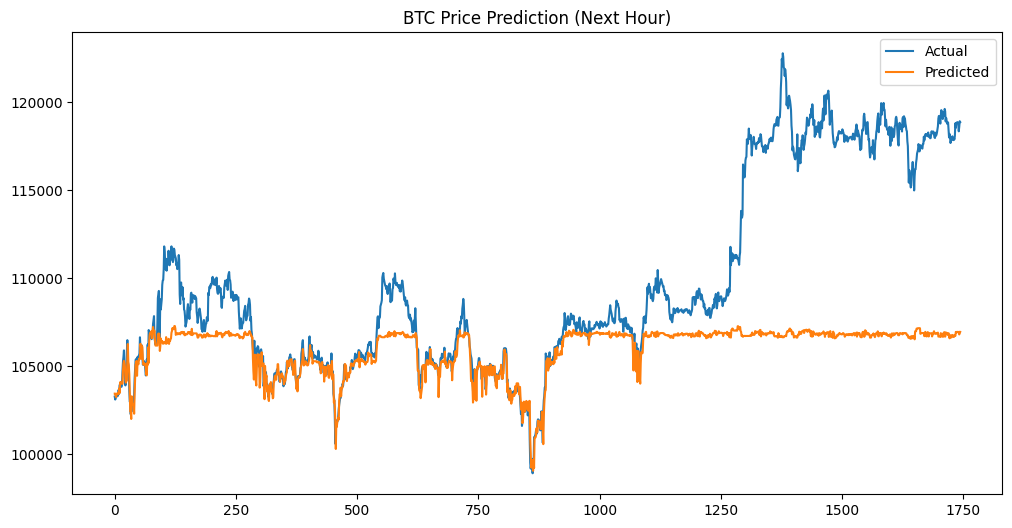

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('BTC Price Prediction (Next Hour)')
plt.legend()
plt.show()


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now split with scaled data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [15]:
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")  # MAE is more interpretable


MSE: 35642883.73
MAE: 3752.27


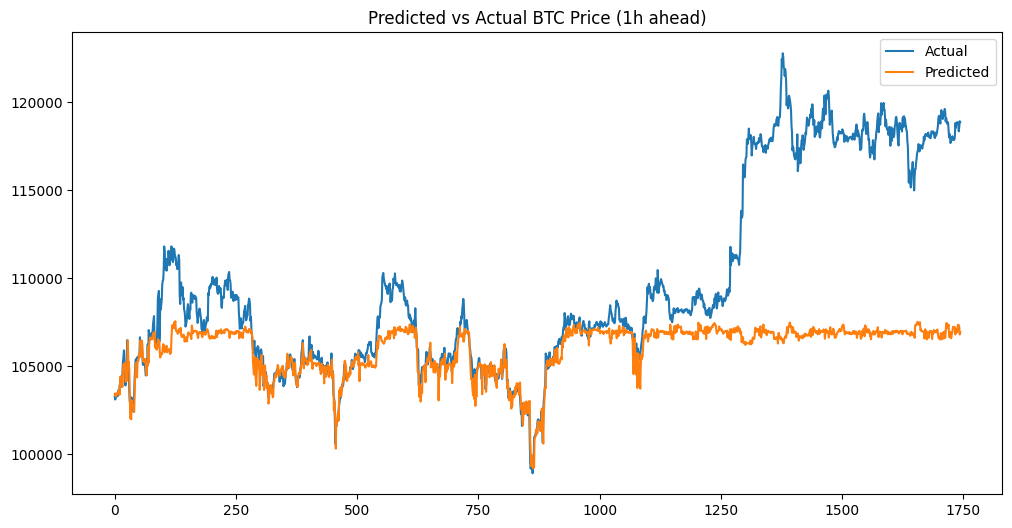

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs Actual BTC Price (1h ahead)')
plt.legend()
plt.show()
